In [19]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import sklearn
import itertools
import jellyfish

from nltk.metrics import distance
# import Pycluster as PC

import requests
import bs4
from bs4 import BeautifulSoup

In [20]:
df = pd.read_csv("/Users/tram/Documents/Learning/itjobs_market_analysis/itjobs_vn/data/data_preprocessing.csv", delimiter = ",", encoding='utf-16')

# Method 1

## 0. Data Cleaning

### 0.1.1. Deal with NULL data

In [21]:
df.isna().sum()/len(df)

id                          0.000000
post_date                   0.000000
title                       0.000000
title_final                 0.000000
sub_group                   0.000000
group                       0.000000
salary                      0.000000
salary_convert              0.000000
salary_average              0.000000
salary_std                  0.000000
precision                   0.000000
salary_new_group            0.000000
skill                       0.293760
skill_group                 0.293760
description                 0.020802
requirement                 0.060883
benefit                     0.064942
location                    0.000000
level                       0.264333
year_experience             0.336377
employer                    0.045662
employer_domain             0.000000
employee_average            0.000000
employer_scale_new_group    0.000000
country                     0.667174
url                         0.000000
portal                      0.000000
d

In [22]:
df.head()

id   post_date  \
0  d86cc43c-4935-42f3-9d78-5a9f1de19424  2023-02-15   
1  1fdc5c63-9300-4d0f-a61f-24b2e0f11e90  2023-03-23   
2  32b89e4c-0983-4300-a9fa-ae5af3ad065e  2023-03-22   
3  09b23ca8-af85-4cf4-a4b1-f342136135e5  2023-03-10   
4  90098b7b-21fa-4b2b-a62f-b2949e5613f4  2023-03-22   

                                               title       title_final  \
0  Chuyên Viên Phân Tích/ Thống Kê (Senior Data A...      data analyst   
1                                  BUSINESS ANALYST   business analyst   
2                                   Business Analyst  business analyst   
3                                   Business Analyst  business analyst   
4                                   Business Analyst  business analyst   

          sub_group group                   salary        salary_convert  \
0      data_analyst  data      18000000 - None VND  774.0 - 9999999999.0   
1  business_analyst  data            100 - 200 IDR         100.0 - 200.0   
2  business_analyst  data            100 - 200 IDR         100.0 - 200.0   
3  business_analyst  data  10000000 - 27000000 VND        430.0 - 1161.0   
4  business_analyst  data           800 - 1500 SGD        600.0 - 1125.0   

   salary_average  salary_std  ...     location level year_experience  \
0           774.0       774.0  ...  ho chi minh   NaN          4 year   
1           150.0        50.0  ...  ho chi minh   NaN          2 year   
2           150.0        50.0  ...  ho chi minh   NaN          2 year   
3           795.5       365.5  ...  ho chi minh   NaN          2 year   
4           862.5       262.5  ...  ho chi minh   NaN          2 year   

  employer                      employer_domain employee_average  \
0      NaN                    apparel & fashion            350.5   
1      NaN               hospital & health care            125.5   
2      NaN                                   in            125.5   
3      NaN                     medical practice            125.5   
4      NaN  information technology and services            350.5   

  employer_scale_new_group country  \
0                 300-4999     NaN   
1                  100-299     NaN   
2                  100-299     NaN   
3                  100-299     NaN   
4                 300-4999     NaN   

                                                 url  portal  
0  https://glints.com/vn/opportunities/jobs/d86cc...  Glints  
1  https://glints.com/vn/opportunities/jobs/1fdc5...  Glints  
2  https://glints.com/vn/opportunities/jobs/32b89...  Glints  
3  https://glints.com/vn/opportunities/jobs/09b23...  Glints  
4  https://glints.com/vn/opportunities/jobs/90098...  Glints  

[5 rows x 27 columns]

**Strategy to fill NULL data:**
* If the null percent >= 0.5: that column is considered as useless and should be dropped. 
* If the null percent < 0.5:
    * With numeric type: set mean or median
    * With categorical type: create new value if NULL percent > 0.1 and get the highest mode value if NULL percent < 0.1.

In [23]:
# 1. Country: be removed
df = df.drop(['country'], axis = 1)

In [24]:
df['year_experience'] = df['year_experience'].fillna("unknown")
df['level'] = df['level'].fillna("unknown")
df['skill'] = df['skill'].fillna("unknown")
df['skill_group'] = df['skill_group'].fillna("unknown")

## 1. Re-group for software jobs
1. Expected outputs: groups include front-end, back-end, full-stack, mobile, others.
2. Strategy:
    * Grouping jobs into 2 classes: clear title to label and unclear title.
    * Define top skill of clear title.
    * Make skill dictionary and re-apply to unclear group.

In [25]:
software_df = df.loc[df['group'] == 'developer']
da_df = df.loc[df['group'] == 'data']

clear_df = software_df.loc[software_df['sub_group'].isin(['frontend', 'backend', 'android'])].reset_index(drop=True)
clear_df.loc[clear_df['sub_group'] == 'android', 'sub_group'] = 'mobile'
unclear_df = software_df.loc[~software_df['sub_group'].isin(['frontend', 'backend', 'android'])].reset_index(drop=True)

In [26]:
clear_df['sub_group'].value_counts()

backend     39
frontend    23
mobile      17
Name: sub_group, dtype: int64

### 1.1. Re-define by title

In [27]:
unclear_df['title_final_1'] = unclear_df['title_final'].apply(lambda x: re.split(" ", x))
title_bow = pd.DataFrame(pd.Series(list(itertools.chain(*unclear_df['title_final_1'].tolist()))).value_counts()).reset_index()
title_bow.columns = ['token', 'count']

In [29]:
# pairing eack token to find out similar words
title_token_pair = pd.DataFrame(list(itertools.product(title_bow['token'].tolist(), title_bow['token'].tolist())))
title_token_pair.columns = ['token_1', 'token_2']
title_token_pair = title_token_pair.loc[title_token_pair['token_1'] != title_token_pair['token_2']]

def pair_sorting(token1, token2):
    output = ", ".join(sorted([token1, token2]))
    return output

title_token_pair['pair_array'] = title_token_pair.apply(lambda x: pair_sorting(x.token_1, x.token_2), axis = 1)
title_token_pair = title_token_pair.drop_duplicates(subset='pair_array')

title_token_pair = pd.merge(title_token_pair,
         title_bow.rename(columns={'count': 'count_token_1'}),
         left_on = 'token_1',
         right_on = 'token',
         how = 'left'
         )

title_token_pair = pd.merge(title_token_pair,
         title_bow.rename(columns={'count': 'count_token_2'}),
         left_on = 'token_2',
         right_on = 'token',
         how = 'left'
         )

title_token_pair = title_token_pair[['token_1', 'token_2', 'count_token_1', 'count_token_2']]

In [30]:
# calculate sim score
title_token_pair['sim_score'] = title_token_pair.apply(lambda x: jellyfish.jaro_winkler_similarity(x.token_1, x.token_2), axis = 1)
title_token_pair.sort_values(by = 'sim_score', ascending=False).iloc[:50]

token_1             token_2  count_token_1  count_token_2  \
15             developer          developers           1498             30   
1300            engineer           engineers             71              1   
2047               unity              unityd             52              1   
13509             bridge              brigde              2              1   
3632                game               games             24              6   
125            developer        developernet           1498              1   
17203       developernet         development              1              1   
1158            frontend         frontendweb             91              1   
3980               react             reactjs             19              8   
659                  net                netc            114              3   
12154                mil                mill              2              2   
2173             android          androidios             51              4   
148            developer       developerhcmc           1498              1   
1354            engineer        engineerteam             71              1   
4507                lead              leader             15              9   
3173          developers        developernet             30              1   
1001            frontend               front             91             19   
130            developer         development           1498              1   
10018            analyst            analysis              4              1   
3296              python          pythonodoo             28              3   
3196          developers       developerhcmc             30              1   
761                  net                cnet            114              1   
237              backend                back            136              7   
9401          salesforce  salesforcemulesoft              4              1   
17397          engineers        engineerteam              1              1   
2469              nodejs         nodejsvuejs             40              1   
6152             reactjs       reactjsnodejs              8              1   
1736                 web               webgl             60              1   
3147          developers              devops             30              2   
75             developer   developerteamlead           1498              2   
3178          developers         development             30              1   
18051         webglvuejs               webgl              1              1   
10905               data            database              3              1   
12323  developerteamlead        developernet              2              1   
1943              mobile       mobileandroid             60              1   
4303               front         frontendweb             19              1   
19133        nodejsvuejs         nodejeactjs              1              1   
4041               react         reactnative             19              2   
955             software  softwareelectronic            110              1   
1378           fullstack                full             63             33   
3375              python              cython             28              1   
17221       developernet       developerhcmc              1              1   
3123          developers   developerteamlead             30              2   
12660                dev              devops              2              2   
16527             dotnet                 dot              1              1   
1659                 web              webapp             60              1   
7294                back          backoffice              7              1   
437                 java          javascript            123              6   
17571        development       developerhcmc              1              1   
12328  developerteamlead         development              2              1   

       sim_score  
15      0.980000  


In [31]:
# create group with its relevant token base on the similarity scores above
title_token_dict = {
    'frontend': ['frontend', 'front', 'frontendweb'],
    'backend': ['backend', 'back'],
    'fullstack': ['fullstack', 'full', 'stack'],
    'mobile': ['mobile', 'android', 'ios', 'mobileandroid']
}

def mark_sub_group(lookings, title_token):
    output = 0
    for each in lookings:
        if each in title_token:
            output = 1
            break
    return output

for group, words in title_token_dict.items():
    unclear_df[group] = unclear_df['title_final_1'].apply(lambda x: mark_sub_group(words, x))

In [32]:
unclear_df.loc[unclear_df['frontend'] == 1, 'sub_group'] = 'frontend'
unclear_df.loc[unclear_df['backend'] == 1, 'sub_group'] = 'backend'
unclear_df.loc[unclear_df['fullstack'] == 1, 'sub_group'] = 'fullstack'
unclear_df.loc[unclear_df['mobile'] == 1, 'sub_group'] = 'mobile'

In [33]:
# merge with the clear data
clear_1_df = pd.concat([unclear_df.loc[unclear_df['sub_group'].isin(['frontend', 'backend', 'fullstack', 'mobile'])][clear_df.columns],
            clear_df],
            axis = 0)

In [34]:
unclear_1_df = unclear_df.loc[~unclear_df['sub_group'].isin(['frontend', 'backend', 'fullstack', 'mobile'])]

### 1.2. Re-define by skills

In [35]:
clear_1_df['skill']

1                                           java,golang
2           fresher accepted, golang, javascript,nodejs
3                                  english, oop,android
4                         angularjs, javascript,angular
6                                      mvc, spring,java
                            ...                        
74          .net, asp.net, entity framework, mongodb,c#
75     backend, java spring framework, microservice,...
76              html, laravel, my sql, unit testing,php
77     c# .net,backend programming, mysql, unit test...
78      c++ language,nan, linux,system analysis,android
Name: skill, Length: 574, dtype: object

In [36]:
def skill_list(skill_str):
    if skill_str == None:
        skill_str = 'unknown'
    listing = re.split(",", skill_str)
    output = [skill.strip() for skill in listing if skill not in ['nan', 'unknown']]
    return output

clear_1_df['skill_1'] = clear_1_df['skill'].apply(lambda x: skill_list(x))
unclear_1_df['skill_1'] = unclear_1_df['skill'].apply(lambda x: skill_list(x))

In [37]:
# set up Bag of Words for sub groups
# threshold = 5
frontend_bow  = pd.Series(list(itertools.chain(*clear_1_df.loc[clear_1_df['sub_group'] == 'frontend']['skill_1'].tolist()))).value_counts()
frontend_bow = frontend_bow[frontend_bow >= 5]
backend_bow = pd.Series(list(itertools.chain(*clear_1_df.loc[clear_1_df['sub_group'] == 'backend']['skill_1'].tolist()))).value_counts()
backend_bow = backend_bow[backend_bow >= 5]
fullstack_bow = pd.Series(list(itertools.chain(*clear_1_df.loc[clear_1_df['sub_group'] == 'fullstack']['skill_1'].tolist()))).value_counts()
mobile_bow = pd.Series(list(itertools.chain(*clear_1_df.loc[clear_1_df['sub_group'] == 'mobile']['skill_1'].tolist()))).value_counts()
mobile_bow = mobile_bow[mobile_bow >= 5]

In [38]:
all_bow = pd.concat([frontend_bow, backend_bow, mobile_bow], axis = 1).reset_index()
all_bow.columns = ['word', 'frontend', 'backend', 'mobile']
all_bow['frontend_rank'] = all_bow['frontend'].rank(ascending=False, method='min')
all_bow['backend_rank'] = all_bow['backend'].rank(ascending=False, method='min')
all_bow['mobile_rank'] = all_bow['mobile'].rank(ascending=False, method='min')

In [39]:
globals()['all_bow'] = all_bow

In [40]:
# functions for define job sub-group base on skill
def define_sub_group(skills):
    global all_bow
    labels = ['frontend', 'backend', 'mobile']
    output = []
    for skill in skills:
        val_arr = all_bow.loc[ all_bow['word'] == skill][['frontend_rank', 'backend_rank', 'mobile_rank']].values
        try:
            output.append(labels[np.nanargmin(val_arr)])
        except:
            pass        
    return output

unclear_1_df['subgroup_by_skill'] = unclear_1_df['skill_1'].apply(lambda x: define_sub_group(x))
unclear_1_df['subgroup_by_skill_length'] = unclear_1_df['subgroup_by_skill'].apply(lambda x: len(x))

In [41]:
# subgroup_more_5 = unclear_1_df.loc[unclear_1_df['subgroup_by_skill_length'] >= 5]
# subgroup_less_5 = unclear_1_df.loc[unclear_1_df['subgroup_by_skill_length'] < 5]

def subgroup_voting(subgroup_list):
    return pd.Series(subgroup_list).value_counts().to_dict()

unclear_1_df['subgroup_voting'] = unclear_1_df['subgroup_by_skill'].apply(lambda x: subgroup_voting(x))

In [42]:
unclear_1_df.head()

id   post_date  \
0   4bad19b6-0970-407a-8dbe-d3136bf832e5  2023-02-07   
5                                ITV4758  2023-03-01   
7                                ITV2502  2023-03-02   
14                               ITV5841  2023-03-03   
16                               ITV1430  2023-03-10   

                                                title  \
0                     Business Intelligence Developer   
5                             Senior NodeJS Developer   
7               [Da Nang] .NET Developer - Upto $2500   
14  Unity Games Developer (C#/Java/Objective C/And...   
16  Fresher/Junior Software Developers in C/C++ Up...   

                        title_final  sub_group      group             salary  \
0   business intelligence developer  developer  developer    1000 - 2500 USD   
5                  nodejs developer  developer  developer     Up to 2000 usd   
7                     net developer  developer  developer  1,000 - 2,500 USD   
14            unity games developer  developer  developer    500 - 2,000 USD   
16           software developers cc  developer  developer        Up to $2000   

     salary_convert  salary_average  salary_std  ...  portal  \
0   1000.0 - 2500.0          1750.0       750.0  ...  Glints   
5      0.0 - 2000.0          2000.0      1000.0  ...  ITViec   
7   1000.0 - 2500.0          1750.0       750.0  ...  ITViec   
14   500.0 - 2000.0          1250.0       750.0  ...  ITViec   
16     0.0 - 2000.0          2000.0      1000.0  ...  ITViec   

                          title_final_1 frontend backend fullstack mobile  \
0   [business, intelligence, developer]        0       0         0      0   
5                   [nodejs, developer]        0       0         0      0   
7                      [net, developer]        0       0         0      0   
14            [unity, games, developer]        0       0         0      0   
16           [software, developers, cc]        0       0         0      0   

                                              skill_1  \
0   [english, etl developer, microsoft sql server,...   
5                         [javascript, vuejs, nodejs]   
7                                [angular, aws, .net]   
14                                 [c#, games, unity]   
16            [c language, c#, fresher accepted, c++]   

                subgroup_by_skill subgroup_by_skill_length  \
0                       [backend]                        1   
5   [frontend, frontend, backend]                        3   
7    [frontend, backend, backend]                        3   
14                      [backend]                        1   
16              [backend, mobile]                        2   

                  subgroup_voting  
0                  {'backend': 1}  
5   {'frontend': 2, 'backend': 1}  
7   {'backend': 2, 'frontend': 1}  
14                 {'backend': 1}  
16    {'backend': 1, 'mobile': 1}  

[5 rows x 35 columns]

In [43]:
def voting_rules(votes):
    result = None
    if len(votes) == 1:
        result = list(votes.keys())[0]
    elif len(votes) > 1:
        labels = list(votes.keys())
        if ('backend' in labels) & ('frontend' in labels):
            if abs(votes['frontend'] - votes['backend']) <= 2:
                result = 'fullstack'
            else:
                if votes['frontend'] > votes['backend']:
                    result = 'frontend'
                else:
                    result = 'backend'
        else:
            if 'frontend' in list(votes.keys()):
                result = 'frontend'
            else:
                result = 'backend'
    return result

unclear_1_df['subgroup_voted'] = unclear_1_df['subgroup_voting'].apply(lambda x: voting_rules(x))

In [44]:
unclear_1_df['subgroup_voted'].value_counts()

backend      381
fullstack    145
frontend      64
mobile        35
Name: subgroup_voted, dtype: int64

In [45]:
unclear_1_df['sub_group'] = unclear_1_df['subgroup_voted']

In [46]:
software_df = pd.concat([clear_1_df, unclear_1_df[clear_1_df.columns]], axis = 0)
software_df['sub_group'].value_counts()

backend      562
fullstack    240
mobile       199
frontend     198
Name: sub_group, dtype: int64

In [ ]:
# # combine with Data Jobs
# df_1 = pd.concat([ df.loc[~df['id'].isin(software_df['id'].tolist())], software_df], axis = 0)

## 2. Re-group for Data & Anlytics jobs

In [47]:
da_df['sub_group'].value_counts()

business_analyst         148
data_analyst              55
data_engineer             49
data_scientist            10
machine_learning           6
business_intelligence      5
ai                         4
Name: sub_group, dtype: int64

The number of data job is very few, consider to re-grouping by similar roles:
* Business Intelligence: merge to Data Analyst, renamed as DA/BI
* Machine Learning, AI: merge to Data Scientist, renamed as DS/ML/AI

In [48]:
da_df.loc[da_df['sub_group'].isin(['data_analyst', 'business_intelligence']), 'sub_group'] = 'DA/BI'
da_df.loc[da_df['sub_group'].isin(['data_scientist', 'machine_learning', 'ai']), 'sub_group'] = 'DS/ML/AI'
da_df.loc[da_df['sub_group'].isin(['business_analyst']), 'sub_group'] = 'BA'
da_df.loc[da_df['sub_group'].isin(['data_engineer']), 'sub_group'] = 'DE'
da_df['sub_group'].value_counts()

BA          148
DA/BI        60
DE           49
DS/ML/AI     20
Name: sub_group, dtype: int64

In [49]:
# combine into new datset
df_1 = pd.concat([software_df, da_df], axis = 0)
df_1.to_csv("/Users/tram/Documents/Learning/itjobs_market_analysis/itjobs_vn/data/data_1971_resubgroup.csv")

# Method 2

In [ ]:
prj_path = '/Users/tram/Documents/Learning/itjobs_market_analysis/itjobs_vn/data/version_2023_03_22/'
# df = pd.read_csv(prj_path+"all_portals.csv", index_col=0)
# df = pd.read_csv(prj_path+"title_preprocessing_01042023.csv", encoding="utf-16", index_col=0)
df = pd.read_csv("Dev_Scrapping_track - Official.csv",
#  delimiter = ",", encoding='utf-16'
 )

In [ ]:
refreshed_cols = ['sub_group', 'group', 'title_final', 'job_sub_group', 'job_group']
df = df.loc[:, [col for col in df.columns if col not in refreshed_cols]]

In [ ]:
# df['salary_num'] = df['salary'].apply(lambda x: re.findall("\d+.?,?\d+", x))
print("Data size:", len(df))

Data size: 513


## 0. Quick EDA

In [ ]:
df['location'].value_counts()

Hồ Chí Minh                                                                                                           214
Hà Nội                                                                                                                193
Hà Nội, Hồ Chí Minh                                                                                                    27
Ho Chi Minh                                                                                                            24
Ha Noi                                                                                                                 15
Ho Chi Minh - Ha Noi                                                                                                    5
Bình Dương                                                                                                              5
Đà Nẵng                                                                                                                 4
Ha Noi - Ho Chi Minh    

(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06]),
 [Text(-0.06, 0, '−0.06'),
  Text(-0.039999999999999994, 0, '−0.04'),
  Text(-0.019999999999999997, 0, '−0.02'),
  Text(0.0, 0, '0.00'),
  Text(0.020000000000000004, 0, '0.02'),
  Text(0.04000000000000001, 0, '0.04'),
  Text(0.06, 0, '0.06')])

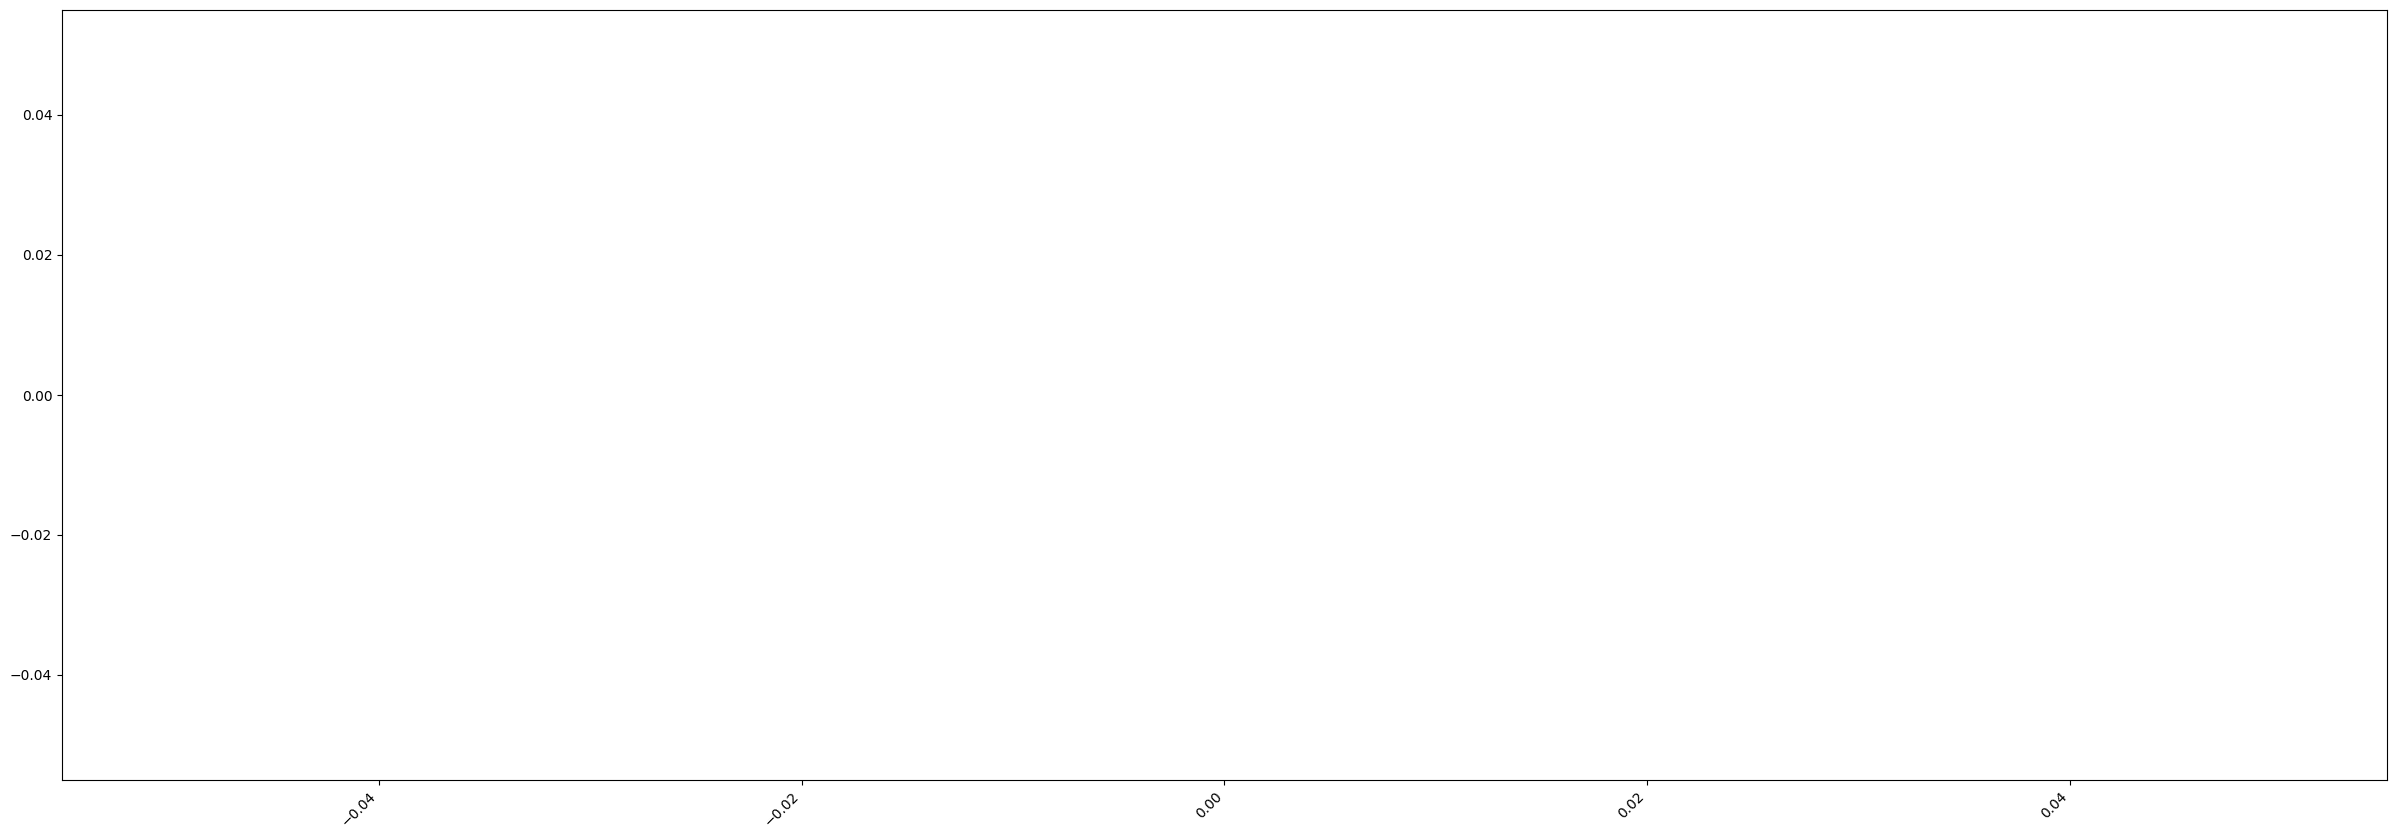

In [ ]:
postdate_count = pd.DataFrame(df['post_date'].value_counts()).reset_index(drop=False)
postdate_count.columns = ['post_date', 'count']
postdate_count = postdate_count.sort_values(by = 'post_date', ascending=True)
postdate_count
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(postdate_count['post_date'], postdate_count['count'])
plt.xticks(rotation=45, ha='right')

## 1. Grouping job by define its relevance

In [ ]:
title_df = df.copy()

In [ ]:
title_df = title_df[['id', 'title']]
# define a bunch of word is in title or not
words_bag = ['developer', 'engineer', 'software', 'data', 'analyst', 'scientist', 'engineer', 'intelligence', 'business', 'machine', 'learning', ' ai ']
title_df['title'] = title_df['title'].apply(lambda x: str(x))
for word in words_bag:  
    title_df[word] = title_df['title'].apply(lambda x: 1 if word in x.lower() else 0)

In [ ]:
# Absolute relevance
developer = title_df.loc[title_df['developer'] == 1]
developer['sub_group'] = 'developer'

software_engineer = title_df.loc[(title_df['software'] == 1) & (title_df['engineer'] == 1) ]
software_engineer['sub_group'] = 'software_engineer'

data_analyst = title_df.loc[(title_df['data'] == 1) & (title_df['analyst'] == 1) ]
data_analyst['sub_group'] = 'data_analyst'

data_engineer = title_df.loc[(title_df['data'] == 1) & (title_df['engineer'] == 1) ]
data_engineer['sub_group'] = 'data_engineer'

data_scientist = title_df.loc[(title_df['data'] == 1) & (title_df['scientist'] == 1) ]
data_scientist['sub_group'] = 'data_scientist'

business_analyst = title_df.loc[(title_df['business'] == 1) & (title_df['analyst'] == 1) ]
business_analyst['sub_group'] = 'business_analyst'

business_intelligence = title_df.loc[(title_df['business'] == 1) & (title_df['intelligence'] == 1) ]
business_intelligence['sub_group'] = 'business_intelligence'

machine_learning = title_df.loc[(title_df['machine'] == 1) & (title_df['learning'] == 1) ]
machine_learning['sub_group'] = 'machine_learning'

ai = title_df.loc[(title_df[' ai '] == 1) ]
ai['sub_group'] = 'ai'

# sure relevant set
relevant_dfs = [developer, software_engineer, data_analyst, data_engineer, data_scientist, business_analyst, business_intelligence, machine_learning, ai]
relevant = pd.concat(relevant_dfs, ignore_index=True).drop_duplicates(subset=['id'])

# unsure relevant set
relevant_ids = []
for a_df in relevant_dfs:
    relevant_ids = relevant_ids + a_df['id'].tolist()
relevant_ids = pd.Series(relevant_ids).unique().tolist()
unsure_relevant = title_df.loc[~title_df['id'].isin(relevant_ids)]

In [ ]:
relevant['sub_group'].value_counts().sum()

251

In [ ]:
unsure_relevant['title_lower'] = unsure_relevant['title'].apply(lambda x: x.lower())

In [ ]:
unsure_relevant['title_tokens'] = unsure_relevant['title_lower'].apply(lambda x: re.split("\s", x.lower()))

In [ ]:
bow = []
for tokens_of_a_title in unsure_relevant['title_tokens']:
    bow = bow + tokens_of_a_title

pd.Series(bow).value_counts().head(50)

data                   33
viên                   28
-                      23
nan                    22
database               19
engineer               18
chuyên                 16
trị                    15
dữ                     15
administrator          15
liệu                   14
nhân                   14
quản                   13
cơ                     12
sở                     12
cloud                   8
specialist              8
&                       8
manager                 7
planning                6
kỹ                      6
sư                      6
(senior                 6
trưởng                  5
phòng                   5
và                      5
vấn                     5
tư                      5
architect               5
administrator)          5
nhập                    4
(data                   4
risk                    4
hàng                    4
khách                   4
                        4
(big                    4
senior                  4
supervisor  

In [ ]:
important_words = ['lập trình viên', 'engineer', 'dev', 'backend', 'frontend', 'web', 'development', 'android']
for word in important_words:
    unsure_relevant[word] = unsure_relevant['title_lower'].apply(lambda x: 1 if word in x.lower() else 0)

removed_words = ['product owner', 'ux', 'ui', 'sale', 'tester']

In [ ]:
lap_trinh_vien = unsure_relevant.loc[unsure_relevant['lập trình viên'] == 1]
lap_trinh_vien['sub_group'] = 'lap_trinh_vien'

backend = unsure_relevant.loc[(unsure_relevant['backend'] == 1) & (~unsure_relevant['title_lower'].str.contains("&".join(removed_words)))]
backend['sub_group'] = 'backend'

frontend = unsure_relevant.loc[(unsure_relevant['frontend'] == 1) & (~unsure_relevant['title_lower'].str.contains("&".join(removed_words)))]
frontend['sub_group'] = 'frontend'

android = unsure_relevant.loc[unsure_relevant['android'] == 1 & (~unsure_relevant['title_lower'].str.contains("&".join(removed_words)))]
android['sub_group'] = 'android'

web = unsure_relevant.loc[(unsure_relevant['web'] == 1) & (~unsure_relevant['title_lower'].str.contains("&".join(removed_words)))]
web['sub_group'] = 'web'

In [ ]:
relevant_lv2 = pd.concat([lap_trinh_vien, backend, frontend, android, web], ignore_index=True).drop_duplicates(subset=['id'])
len(relevant_lv2)

2

In [ ]:
unsure_relevant_lv2 = unsure_relevant.loc[~unsure_relevant['id'].isin(relevant_lv2['id'].tolist())]

In [ ]:
unsure_relevant_lv2.loc[unsure_relevant_lv2['data'] == 1]
DA_variance = ['analysis', 'analytics', 'manager']

data_analyst_lv2 = unsure_relevant_lv2.loc[(unsure_relevant_lv2['data'] == 1) & unsure_relevant_lv2['title_lower'].str.contains("|".join(DA_variance))]
data_analyst_lv2['sub_group'] = 'data_analyst'

In [ ]:
final_relevant = pd.concat([relevant, relevant_lv2, data_analyst_lv2], ignore_index=True)
len(final_relevant)

256

In [ ]:
group_stats = pd.DataFrame(final_relevant['sub_group'].value_counts()).reset_index(drop=False).rename(columns={'index': 'word_group', 'sub_group': 'count'})
group_dict = {'developer': ['developer', 'lap_trinh_vien', 'software_engineer', 'backend', 'frontend', 'web', 'android'], 
              'data': ['data_analyst', 'data_scientist', 'data_engineer', 'business_analyst', 'business_intelligence', 'machine_learning', 'ai']
              }

def define_group(sub_group):
    for group, sub in group_dict.items():
        if sub_group in sub:
            return group

group_stats['group'] = group_stats['word_group'].apply(lambda x: define_group(x))
group_stats.groupby('group')['count'].sum()

group
data         239
developer     17
Name: count, dtype: int64

In [ ]:
group_stats

word_group  count      group
0        business_analyst     84       data
1           data_engineer     81       data
2            data_analyst     47       data
3               developer     13  developer
4          data_scientist     13       data
5        machine_learning      6       data
6   business_intelligence      5       data
7                      ai      3       data
8       software_engineer      2  developer
9                 backend      1  developer
10                    web      1  developer

In [ ]:
id_with_group = pd.merge(final_relevant, group_stats[['word_group', 'group']], left_on='sub_group', right_on='word_group', how = 'left')[['id', 'sub_group', 'group']]

In [ ]:
selected_df = pd.merge(df, id_with_group, on = 'id', how = 'left')
selected_df = selected_df.loc[selected_df['group'].notna()].reset_index(drop=True)

In [ ]:
# selected_df.to_csv(prj_path + "official_sample_1578.csv")

## 2. Cleaning & grouping jobs base on title

### Step 1: Cleaning the title

In [ ]:
title_df = selected_df[['title']]
title_df.head()

title
0     Business Analyst Triển Khai Phần Mềm ERM | CRM
1                            Business Analyst Leader
2                 Business Analyst Thu Nhập Upto 30M
3  Nhân Viên Triển Khai Phần Mềm Kế Toán Fast - B...
4                            Senior Business Analyst

In [ ]:
def within_parentheses_remove(title):
    new_title = title
    removed = re.findall("(\(.*?\))", new_title)
    for each in removed:
        new_title = new_title.replace(each, "").strip()
    return new_title

def within_square_remove(title):
    new_title = title
    removed = re.findall("(\[.*?\])", new_title)
    for each in removed:
        new_title = new_title.replace(each, "").strip()
    return new_title

def num_punct_remove(title):
    new_title = title
    numbers = re.findall("(\d+)", new_title)
    for n in numbers:
        new_title = new_title.replace(n, "").strip()
    for p in string.punctuation:
        new_title = new_title.replace(p, "").strip()
    return new_title

def level_remove(title):
    new_title = title.lower()
    level_terms = ['senior', 'junior', 'fresher', 'sr']
    for lev in level_terms:
        new_title = new_title.replace(lev, "").strip()
    return new_title

def others_remove(title):
    new_title = title.lower()
    other_terms = ['up to']
    for term in other_terms:
        new_title = new_title.replace(term, "").strip()
    return new_title


title_df['title_cleaned'] = title_df['title'].apply(lambda x: within_parentheses_remove(x))
title_df['title_cleaned'] = title_df['title_cleaned'].apply(lambda x: within_square_remove(x))
title_df['title_cleaned'] = title_df['title_cleaned'].apply(lambda x: num_punct_remove(x))
title_df['title_cleaned'] = title_df['title_cleaned'].apply(lambda x: level_remove(x))
title_df['title_cleaned'] = title_df['title_cleaned'].apply(lambda x: others_remove(x))
title_df.head()

title  \
0     Business Analyst Triển Khai Phần Mềm ERM | CRM   
1                            Business Analyst Leader   
2                 Business Analyst Thu Nhập Upto 30M   
3  Nhân Viên Triển Khai Phần Mềm Kế Toán Fast - B...   
4                            Senior Business Analyst   

                                       title_cleaned  
0      business analyst triển khai phần mềm erm  crm  
1                            business analyst leader  
2                   business analyst thu nhập upto m  
3  nhân viên triển khai phần mềm kế toán fast  bu...  
4                                   business analyst

In [ ]:
title_unique_values = title_df['title_cleaned'].value_counts()
title_unique_values
#distance.edit_distance('net developer', working['title_cleaned'][0])

business analyst                                 59
data engineer                                    33
data analyst                                     30
data scientist                                   29
it business analyst                              12
                                                 ..
business analyst support                          1
business analyst  mis  equest education group     1
nhân viên lập trình web                           1
data analyst  tnex  z14                           1
be developer   m                                  1
Name: title_cleaned, Length: 131, dtype: int64

In [ ]:
title_unique = pd.DataFrame({'title_unique': list(title_unique_values.keys())})#.to_csv("itjobs_title_unique_values_ver1.csv")

### Step 2: Tokenize title

In [ ]:
# tokenize function
def tokenize(title):
    word_list = re.split(r'\s', title)
    tokens = [word for word in word_list if len(word) > 1]
    return tokens
title_unique['tokens']  = title_unique['title_unique'].apply(lambda x: tokenize(x))
title_unique.head(10)


title_unique  \
0                       business analyst   
1                          data engineer   
2                           data analyst   
3                         data scientist   
4                    it business analyst   
5  risk analystdata scientist sql python   
6   risk analystdata scientist sqlpython   
7             nhân viên business analyst   
8                     data engineer zalo   
9                business analyst leader   

                                        tokens  
0                          [business, analyst]  
1                             [data, engineer]  
2                              [data, analyst]  
3                            [data, scientist]  
4                      [it, business, analyst]  
5  [risk, analystdata, scientist, sql, python]  
6    [risk, analystdata, scientist, sqlpython]  
7              [nhân, viên, business, analyst]  
8                       [data, engineer, zalo]  
9                  [business, analyst, leader]

In [ ]:
token_bow = []
for tokens_one_title in title_unique['tokens']:
    for token in tokens_one_title:
        token_bow.append(token)

token_bow_dict = {}
for token in token_bow:
    if token not in list(token_bow_dict.keys()):
        token_bow_dict[token] = 1
    else: 
        token_bow_dict[token] += 1

token_bow_dict = dict(sorted(token_bow_dict.items(), key=lambda item: item[1], reverse=True))


In [ ]:
token_counts_df = pd.DataFrame({'token': list(token_bow_dict.keys()), 
              'count': list(token_bow_dict.values())
})

# detect language of token
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

language_list = []
for row in token_counts_df['token']:
    try:
        language = detect(row)
        language_list.append(language)
    except:
        language = "error"
        language_list.append(language)

token_counts_df['language'] = language_list

### Cleaning for specific languages
#### Vietnamese

In [ ]:
# For Vinh: priority 1st
vi_tokens = token_counts_df.loc[token_counts_df['language'] == 'vi']['token'].tolist()
# remove useless tokens
vi_useless_tokens = ['tháng','lương', 'upto', 'kcn', 'quang', 'minh', 'ml', 'hn', 'hcmc', 'vinhomes', 'hcm', 'month', 'signing', 'bonus'
'bắc', 'giang', 'tuyển', 'gấp', 'có', 'thể', 'đi', 'làm', 'sau', 'tết', 'urgent','buca','Joint','Stock', 'Company','uses','python','gcp','tphcm'
]
vi_tokens_cleaned = [token for token in vi_tokens if token not in vi_useless_tokens]

In [ ]:
title_unique.head()

title_unique                   tokens  vi
0     business analyst      [business, analyst]   0
1        data engineer         [data, engineer]   0
2         data analyst          [data, analyst]   0
3       data scientist        [data, scientist]   0
4  it business analyst  [it, business, analyst]   0

In [ ]:
def vi_title_detect(title_tokens):
    output = 0
    for searched_token in title_tokens:
        if searched_token in vi_tokens_cleaned:
            output = 1
            break
    return output

title_unique['vi'] = title_unique['tokens'].apply(lambda x: vi_title_detect(x))
vi_title_df = title_unique.loc[title_unique['vi'] == 1]

def vi_tokens_cleaned(title_tokens):
    return [token for token in title_tokens if token not in vi_useless_tokens]

vi_title_df['tokens_cleaned'] = vi_title_df['tokens'].apply(lambda x: vi_tokens_cleaned(x))
vi_title_df['title_cleaned'] = vi_title_df['tokens_cleaned'].apply(lambda x: " ".join(x))

In [ ]:
# translate
from translate import Translator
translator= Translator(from_lang="vi", to_lang="en")

def title_english(title):
    try:
        translation = translator.translate(title)
    except:
        translation = title
    return  translation

vi_title_df['title_translated'] = vi_title_df['title_cleaned'].apply(lambda x: (title_english(x)))

7     NaN
12    NaN
15    NaN
17    NaN
20    NaN
27    NaN
28    NaN
32    NaN
33    NaN
37    NaN
40    NaN
41    NaN
43    NaN
44    NaN
45    NaN
47    NaN
48    NaN
49    NaN
51    NaN
56    NaN
60    NaN
71    NaN
76    NaN
77    NaN
83    NaN
85    NaN
92    NaN
94    NaN
106   NaN
108   NaN
112   NaN
116   NaN
122   NaN
128   NaN
Name: tokens_cleaned, dtype: float64

In [ ]:
vi_title_df

title_unique  \
7                           nhân viên business analyst   
12    công ty cổ phần buca tuyển dụng business analyst   
15   việc làm  python developerdata engineer tại tp...   
17                              nhân viên data analyst   
20                     chuyên viên phân tích nghiệp vụ   
27            chuyên viên phân tích nghiệp vụ phần mềm   
28                                       kỹ sư dữ liệu   
32                            chuyên viên data analyst   
33                                       lập trình web   
37       business analyst triển khai phần mềm erm  crm   
40               phân tích nghiệp vụ  business analyst   
41   chuyên vien phân tích kinh doanh  business ana...   
43            nhân viên phân tích dữ liệu data analyst   
44                       nhân viên ba business analyst   
45   tuyển dụng data analyst ưu tiên biết macro sql...   
47                         nhân viên phân tích dữ liệu   
48   data engineer  cơ hội việc làm hấp dẫn với mức...   
49                    data engineer   tan phu district   
51   nhân viên triển khai phần mềm kế toán fast  bu...   
56                    business analyst thu nhập upto m   
60    business intelligence thu nhập hấp dẫn lên tới m   
71                                 kỹ sư data engineer   
76                           kỹ sư dữ liệu   ban dự án   
77   công ty trang sức jemmia tuyển dụng fulltime q...   
83          chuyên viên big data developer tại admicro   
85   công ty audience serv tuyển dụng data  system ...   
92                      business analyst  khối dữ liệu   
94   công ty chuyển phát nhanh ahamove tuyển dụng t...   
106                      nhân viên it business analyst   
108              business analyst  từ  năm kinh nghiệm   
112            cvcc nghiên cứu phát triển công nghệ ai   
116  chuyên giachuyên viên cao cấp   trung tâm công...   
122                 business analyst leader tại hà nội   
128                            nhân viên lập trình web   

                                                tokens  vi  \
7                      [nhân, viên, business, analyst]   1   
12   [công, ty, cổ, phần, buca, tuyển, dụng, busine...   1   
15   [việc, làm, python, developerdata, engineer, t...   1   
17                         [nhân, viên, data, analyst]   1   
20              [chuyên, viên, phân, tích, nghiệp, vụ]   1   
27   [chuyên, viên, phân, tích, nghiệp, vụ, phần, mềm]   1   
28                                  [kỹ, sư, dữ, liệu]   1   
32                       [chuyên, viên, data, analyst]   1   
33                                   [lập, trình, web]   1   
37   [business, analyst, triển, khai, phần, mềm, er...   1   
40         [phân, tích, nghiệp, vụ, business, analyst]   1   
41   [chuyên, vien, phân, tích, kinh, doanh, busine...   1   
43   [nhân, viên, phân, tích, dữ, liệu, data, analyst]   1   
44                 [nhân, viên, ba, business, analyst]   1   
45   [tuyển, dụng, data, analyst, ưu, tiên, biết, m...   1   
47                  [nhân, viên, phân, tích, dữ, liệu]   1   
48   [data, engineer, cơ, hội, việc, làm, hấp, dẫn,...   1   
49                [data, engineer, tan, phu, district]   1   
51   [nhân, viên, triển, khai, phần, mềm, kế, toán,...   1   
56                [business, analyst, thu, nhập, upto]   1   
60   [business, intelligence, thu, nhập, hấp, dẫn, ...   1   
71                            [kỹ, sư, data, engineer]   1   
76                     [kỹ, sư, dữ, liệu, ban, dự, án]   1   
77   [công, ty, trang, sức, jemmia, tuyển, dụng, fu...   1   
83   [chuyên, viên, big, data, developer, tại, admi...   1   
85   [công, ty, audience, serv, tuyển, dụng, data, ...   1   
92                 [business, analyst, khối, dữ, liệu]   1   
94   [công, ty, chuyển, phát, nhanh, ahamove, tuyển...   1   
106                [nhân, viên, it, business, analyst]   1   
108         [business, analyst, từ, năm, kinh, nghiệm]   1   
112   [cvcc, nghiên, cứu, phát, triển, công, nghệ, ai]   1   
116  [chuyên, giachuyên, vi

In [ ]:
'tan','phu','district','thu','nhập','hấp','dẫn','lên','tới',''

#### English

In [ ]:
# token cleanning for English Title
# For Vinh: priority 1st
en_title_df = title_unique.loc[title_unique['vi'] == 0]
en_tokens = token_counts_df.loc[token_counts_df['language'] != 'vi']['token'].tolist()
en_tokens
en_useless_tokens = ['upto', 'bonus', 'kcn', 'lý', 'ml', 'hn', 'hcmc', 'mid', 'salary', 'month', 'urgent', 'singapore', 'middle', 'hybrid', 'level', 
'tet', 'levels', 'cntt', 'vnd', 'signing', 'yêu', 'hydridremote', 'in', 'ha', 'noi', 'remotehybrid', 'usd', 'japanese', 'python','sql',
'speaking', 'working', 'vinhomes', 'midlevel', 'after', 'before', 'onboard', 'th',
 'có', 'thể', 'đi', 'làm', 'sau', 'tết']

def en_tokens_cleaned(title_tokens):
    return [token for token in title_tokens if token not in en_useless_tokens]

en_title_df['tokens_cleaned'] = en_title_df['tokens'].apply(lambda x: en_tokens_cleaned(x))
en_title_df['title_cleaned'] = en_title_df['tokens_cleaned'].apply(lambda x: " ".join(x))

In [ ]:
len(en_title_df)

92

In [ ]:
len(vi_title_df)

39

In [ ]:
# merging vi and en title into final file. The file "final_title_unique" is just the unique values counted, not the real dataset
final_title_unique = pd.concat([en_title_df, vi_title_df], axis = 0)
len(final_title_unique)

131

In [ ]:
# final_title_unique

In [ ]:
final_title_df = pd.merge(title_df, final_title_unique, left_on='title_cleaned', right_on = ['title_unique'], how = 'left')
# final_title_df = final_title_df[['title', 'title_final']]

In [ ]:
final_title_df['title_cleaned_y'].value_counts()

business analyst                                                                                                                                63
data engineer                                                                                                                                   37
data analyst                                                                                                                                    31
data scientist                                                                                                                                  29
it business analyst                                                                                                                             14
risk analystdata scientist                                                                                                                       6
risk analystdata scientist sqlpython                                                                                  

In [ ]:
# merged with full dataset
df_cleaned_title = pd.merge(selected_df, final_title_df, left_on = 'title', right_on='title', how = 'left').drop_duplicates(subset=['id']).reset_index(drop=True)

In [ ]:
print("Number of job got empty title after cleaning:", len(df_cleaned_title.loc[df_cleaned_title['title_final'].isna()]))

### Step bonus (frequently updated): synonym term dictionary

In [ ]:
# For Vinh: priority 2nd
synonym_dict = {
    'dev': 'developer',
    'developers': 'developer',
    'developer(s)': 'developer',
    'engineers': 'engineer',
    'games': 'game',
    'back end': 'backend',
    'back-end': 'backend',
    'front end': "frontend",
    'front-end': "front-end"
}

def synonym_detect_and_correct(tokens):
    for i in range(len(tokens)):
        for current, corrected in synonym_dict.items():
            if tokens[i] == current:
                tokens[i] = corrected
    return tokens

final_title_df['title_final'] = final_title_df['title_final'].apply(lambda x: synonym_detect_and_correct(x))

### Step 3: Tokenize again to grouping job title

In [ ]:
no_sub_group = df_cleaned_title.loc[(df_cleaned_title["sub_group"].isnull()) & (df_cleaned_title["group"].isnull()),["id","title_final","sub_group","group"]].drop_duplicates()

In [ ]:
no_sub_group['title_final']

In [ ]:
no_sub_group['tokens'] = no_sub_group['title_final'].apply(lambda x: tokenize(x.lower()))
no_sub_group['tokens_cleaned'] = no_sub_group['tokens'].apply(lambda x: synonym_detect_and_correct(x))
no_sub_group.head()

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
token_bow = []
for tokens_one_title in final_title_df['tokens_cleaned']:
    for token in tokens_one_title:
        token_bow.append(token)

token_bow_dict = {}
for token in token_bow:
    if token not in list(token_bow_dict.keys()):
        token_bow_dict[token] = 1
    else: 
        token_bow_dict[token] += 1

token_bow_dict = dict(sorted(token_bow_dict.items(), key=lambda item: item[1], reverse=True))
token_bow_dict

{'developer': 1177,
 'programmer': 201,
 'analyst': 163,
 'backend': 155,
 'engineer': 142,
 'business': 137,
 'net': 128,
 'java': 118,
 'frontend': 111,
 'data': 97,
 'software': 91,
 'php': 87,
 'mobile': 75,
 'unity': 72,
 'android': 71,
 'end': 65,
 'the': 63,
 'web': 58,
 'nodejs': 50,
 'ios': 46,
 'front': 43,
 'fullstack': 41,
 'flutter': 41,
 'stack': 40,
 'game': 37,
 'it': 26,
 'react': 25,
 'native': 24,
 'reactjs': 24,
 'back': 22,
 'wordpress': 17,
 'vuejs': 15,
 'lead': 14,
 'embedded': 13,
 'golang': 12,
 'python': 12,
 'javascript': 11,
 'staff': 11,
 'angular': 11,
 'intelligence': 10,
 'blockchain': 9,
 'analysis': 9,
 'specialist': 8,
 'machine': 8,
 'learning': 8,
 'ruby': 8,
 'salesforce': 8,
 'programming': 8,
 'system': 7,
 'on': 7,
 'rails': 7,
 'scientist': 7,
 'manager': 7,
 'odoo': 7,
 'magento': 6,
 'owner': 6,
 'with': 5,
 'technical': 5,
 'core': 5,
 'and': 5,
 'program': 5,
 'integration': 4,
 'bridge': 4,
 'securities': 4,
 'sap': 4,
 'test': 4,
 'qa': 

In [ ]:
token_list = list(token_bow_dict.keys())

token_matrix = pd.DataFrame(np.zeros(shape=(len(token_list),len(token_list))), columns = token_list, index=token_list)
token_matrix

developer  programmer  analyst  backend  engineer  business  \
developer           0.0         0.0      0.0      0.0       0.0       0.0   
programmer          0.0         0.0      0.0      0.0       0.0       0.0   
analyst             0.0         0.0      0.0      0.0       0.0       0.0   
backend             0.0         0.0      0.0      0.0       0.0       0.0   
engineer            0.0         0.0      0.0      0.0       0.0       0.0   
...                 ...         ...      ...      ...       ...       ...   
rd                  0.0         0.0      0.0      0.0       0.0       0.0   
delivery            0.0         0.0      0.0      0.0       0.0       0.0   
statistician        0.0         0.0      0.0      0.0       0.0       0.0   
rewards             0.0         0.0      0.0      0.0       0.0       0.0   
hr                  0.0         0.0      0.0      0.0       0.0       0.0   

              net  java  frontend  data  ...   vb  dot  design  marketing  \
developer     0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
programmer    0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
analyst       0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
backend       0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
engineer      0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
...           ...   ...       ...   ...  ...  ...  ...     ...        ...   
rd            0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
delivery      0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
statistician  0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
rewards       0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
hr            0.0   0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   

              programmer.   rd  delivery  statistician  rewards   hr  
developer             0.0  0.0       0.0           0.0      0.0  0.0  
programmer            0.0  0.0       0.0           0.0      0.0  0.0  
analyst               0.0  0.0       0.0           0.0      0.0  0.0  
backend               0.0  0.0       0.0           0.0      0.0  0.0  
engineer              0.0  0.0       0.0           0.0      0.0  0.0  
...                   ...  ...       ...           ...      ...  ...  
rd                    0.0  0.0       0.0           0.0      0.0  0.0  
delivery              0.0  0.0       0.0           0.0      0.0  0.0  
statistician          0.0  0.0       0.0           0.0      0.0  0.0  
rewards               0.0  0.0       0.0           0.0      0.0  0.0  
hr                    0.0  0.0       0.0           0.0      0.0  0.0  

[230 rows x 230 columns]

In [ ]:
for a_title in final_title_df['tokens_cleaned']:
    pairs = []
    for pair in list(itertools.product(a_title, a_title)):
        if (pair[0] != pair[1]) & (sorted(pair) not in pairs):
            pairs.append(sorted(pair))

    for pair in pairs:
        token_matrix.at[pair[0], pair[1]] += 1
        token_matrix.at[pair[1], pair[0]] += 1

In [ ]:
token_matrix.head(10)

developer  programmer  analyst  backend  engineer  business  \
developer         0.0         7.0      1.0    121.0       2.0       2.0   
programmer        7.0         0.0      0.0     12.0       3.0       0.0   
analyst           1.0         0.0      0.0      0.0       1.0     126.0   
backend         121.0        12.0      0.0      0.0      16.0       0.0   
engineer          2.0         3.0      1.0     16.0       0.0       0.0   
business          2.0         0.0    126.0      0.0       0.0       0.0   
net             117.0         5.0      0.0     13.0       4.0       0.0   
java            110.0         0.0      1.0     14.0       3.0       1.0   
frontend         92.0         6.0      0.0      1.0      10.0       0.0   
data              1.0         0.0     35.0      1.0      42.0       0.0   

              net   java  frontend  data  ...   vb  dot  design  marketing  \
developer   117.0  110.0      92.0   1.0  ...  1.0  1.0     0.0        0.0   
programmer    5.0    0.0       6.0   0.0  ...  0.0  0.0     0.0        0.0   
analyst       0.0    1.0       0.0  35.0  ...  0.0  0.0     0.0        1.0   
backend      13.0   14.0       1.0   1.0  ...  0.0  0.0     0.0        0.0   
engineer      4.0    3.0      10.0  42.0  ...  0.0  0.0     1.0        0.0   
business      0.0    1.0       0.0   0.0  ...  0.0  0.0     0.0        1.0   
net           0.0    2.0       6.0   0.0  ...  0.0  1.0     0.0        0.0   
java          2.0    0.0       2.0   0.0  ...  0.0  0.0     0.0        0.0   
frontend      6.0    2.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   
data          0.0    0.0       0.0   0.0  ...  0.0  0.0     0.0        0.0   

            programmer.   rd  delivery  statistician  rewards   hr  
developer           0.0  0.0       0.0           0.0      0.0  0.0  
programmer          0.0  0.0       0.0           0.0      0.0  0.0  
analyst             1.0  0.0       0.0           0.0      0.0  0.0  
backend             0.0  0.0       0.0           0.0      0.0  0.0  
engineer            0.0  0.0       0.0           0.0      0.0  0.0  
business            1.0  0.0       0.0           0.0      0.0  0.0  
net                 0.0  0.0       0.0           0.0      0.0  0.0  
java                0.0  0.0       0.0           0.0      0.0  0.0  
frontend            0.0  0.0       0.0           0.0      0.0  0.0  
data                0.0  0.0       1.0           0.0      1.0  1.0  

[10 rows x 230 columns]

In [ ]:
pair_df = pd.melt(token_matrix.reset_index(), id_vars='index', value_vars=token_matrix.columns).rename(columns={'index': 'word_1', 'variable': 'word_2'})

# drop duplicates of pairs
def order_and_get_first_word(word_1, word_2):
    list_ = sorted([word_1, word_2])
    return list_[0]

def order_and_get_second_word(word_1, word_2):
    list_ = sorted([word_1, word_2])
    return list_[1]

pair_df['word_1_sorted'] = pair_df.apply(lambda x: order_and_get_first_word(x.word_1, x.word_2), axis = 1)
pair_df['word_2_sorted'] = pair_df.apply(lambda x: order_and_get_second_word(x.word_1, x.word_2), axis = 1)

pair_df = pair_df.drop_duplicates(subset=['word_1_sorted', 'word_2_sorted', 'value'])

In [ ]:
# Show the pair table
pair_df.loc[pair_df['value'] > 1].sort_values(by='value', ascending=False)

word_1     word_2  value word_1_sorted word_2_sorted
465    business    analyst  126.0       analyst      business
3       backend  developer  121.0       backend     developer
6           net  developer  117.0     developer           net
7          java  developer  110.0     developer          java
8      frontend  developer   92.0     developer      frontend
...         ...        ...    ...           ...           ...
72      laravel  developer    2.0     developer       laravel
1477   exchange        net    2.0      exchange           net
1618   frontend       java    2.0      frontend          java
1626        the       java    2.0          java           the
27259       ads   playable    2.0           ads      playable

[282 rows x 5 columns]

In [ ]:
main_keywords = ['developer', 'engineer', 'business', 'data']    # very little rows of "data"

threshold = 3
title_group_dict = {}
for key in main_keywords:
    paired_words = token_matrix[key].sort_values(ascending=False)[token_matrix[key].sort_values(ascending=False) >=threshold].keys().tolist()
    title_group_dict[key] = paired_words

In [ ]:
# final
title_group_dict

{'developer': ['backend',
  'net',
  'java',
  'frontend',
  'php',
  'unity',
  'end',
  'mobile',
  'android',
  'web',
  'ios',
  'nodejs',
  'front',
  'stack',
  'fullstack',
  'software',
  'game',
  'the',
  'flutter',
  'react',
  'native',
  'back',
  'reactjs',
  'wordpress',
  'vuejs',
  'lead',
  'it',
  'golang',
  'javascript',
  'ruby',
  'programmer',
  'on',
  'embedded',
  'rails',
  'staff',
  'salesforce',
  'odoo',
  'blockchain',
  'magento',
  'angular',
  'system',
  'with',
  'program',
  'python',
  'team',
  'technical',
  'securities',
  'core',
  'programming',
  'front-end',
  'sap',
  'firmware',
  'to'],
 'engineer': ['software',
  'data',
  'backend',
  'frontend',
  'machine',
  'android',
  'embedded',
  'learning',
  'net',
  'big',
  'web',
  'bridge',
  'java',
  'programmer',
  'lead',
  'test',
  'qa',
  'research'],
 'business': ['analyst', 'it', 'intelligence', 'experience'],
 'data': ['engineer',
  'analyst',
  'analysis',
  'scientist',
  'sp

In [ ]:
# add column of job group
def define_sub_group(title):
    title_tokens = title.split(" ")
    group_defined = []
    for a_token in title_tokens:
        for group, words in title_group_dict.items():
            if a_token in words:
                group_defined.append(group)
    return group_defined

def define_group(group):
    for i in group:
        if i in ['developer', 'engineer']:
            return "web/software development"
        elif i in ['data', 'business']:
            return "data"
        else:
            return None
        
df_cleaned_title['job_sub_group'] = df_cleaned_title['title_final'].apply(lambda x: define_sub_group(x))
df_cleaned_title['job_group'] = df_cleaned_title['job_sub_group'].apply(lambda x: define_group(x))
df_cleaned_title = df_cleaned_title.loc[df_cleaned_title['job_group'].notna()]

AttributeError: 'float' object has no attribute 'split'

In [ ]:
pd.set_option('display.max_rows', 500)  # or 1000
df_cleaned_title["job_group"] = df_cleaned_title["job_group"].apply(lambda x: str(x))
df_cleaned_title.loc[(df_cleaned_title["job_group"] == "None"),["id","title","title_final","tokens_cleaned","job_sub_group","job_group"]]

KeyError: "['tokens_cleaned'] not in index"

In [ ]:
pd.set_option('display.max_rows', 310)  # or 1000
df_cleaned_title[["title","title_final","job_group",]]

## With titles are empty after cleaning, paste the sub group as their name

In [ ]:
empty_final_title = df_cleaned_title.loc[df_cleaned_title['title_final'].isna()]

In [ ]:
old_sub_group = selected_df['sub_group'].unique().tolist()
new_sub_group = []
for sub_name in old_sub_group:
    new_sub_name_1 = sub_name.replace("_", " ")
    
    if new_sub_name_1 == "lap trinh vien":
        new_sub_name_2 = 'developer'
    elif new_sub_name_1 == "backend":
        new_sub_name_2 = "backend developer"
    elif new_sub_name_1 == "frontend":
        new_sub_name_2 = "frontend developer"
    elif new_sub_name_1 == "web":
        new_sub_name_2 = "web developer"
    elif new_sub_name_1 == 'android':
        new_sub_name_2 = "android developer"
    elif new_sub_name_1 == 'ai':
        new_sub_name_2 = "ai engineer"
    else:
        new_sub_name_2 = new_sub_name_1

    new_sub_group.append(new_sub_name_2)

In [ ]:
title_final_df_2 = pd.DataFrame({'sub_group': old_sub_group, 'title_final_2': new_sub_group})
fill_empty_title = pd.merge(empty_final_title, title_final_df_2, on = 'sub_group', how = 'left')
fill_empty_title = fill_empty_title.drop(columns=['title_final'])
fill_empty_title= fill_empty_title.rename(columns={'title_final_2': 'title_final'})

In [ ]:
very_final_df = pd.concat([
    df_cleaned_title.loc[df_cleaned_title['title_final'].notna()],
    fill_empty_title],
    ignore_index=True
)

In [ ]:
# check before export
very_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               1972 non-null   object
 1   post_date        1972 non-null   object
 2   title            1972 non-null   object
 3   skills           1221 non-null   object
 4   salary           1971 non-null   object
 5   url              1972 non-null   object
 6   location         1972 non-null   object
 7   description      1931 non-null   object
 8   requirement      1851 non-null   object
 9   benefit          1843 non-null   object
 10  level            1459 non-null   object
 11  year_experience  1309 non-null   object
 12  employer         1881 non-null   object
 13  employer_domain  572 non-null    object
 14  employer_scale   1944 non-null   object
 15  country          656 non-null    object
 16  portal           1972 non-null   object
 17  skill            174 non-null    

In [ ]:
very_final_df.to_csv("/Users/tram/Documents/Learning/itjobs_market_analysis/itjobs_vn/data/version_2023_03_22/all_cleaned_title_nrow1972_20230403.csv")